In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from prg import prg
np.random.seed(7)

from keras.regularizers import l2
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ProgbarLogger
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler

from retreive_data import unpack_gzip

import keras.backend as K

#sess = tf.Session()

Using TensorFlow backend.


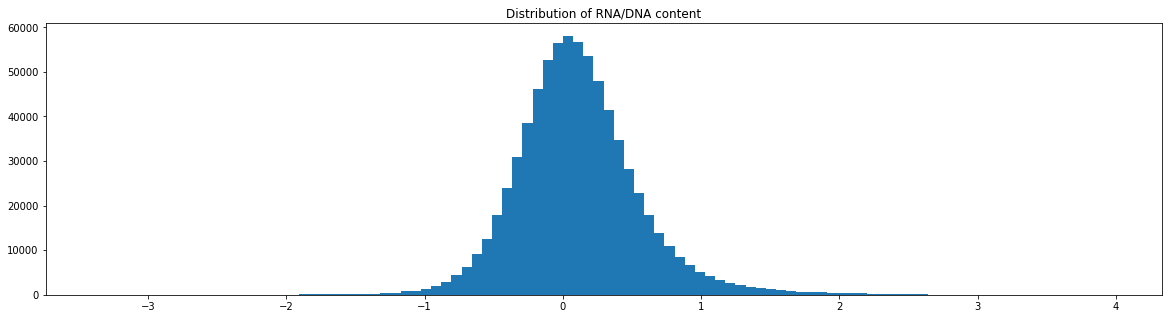

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


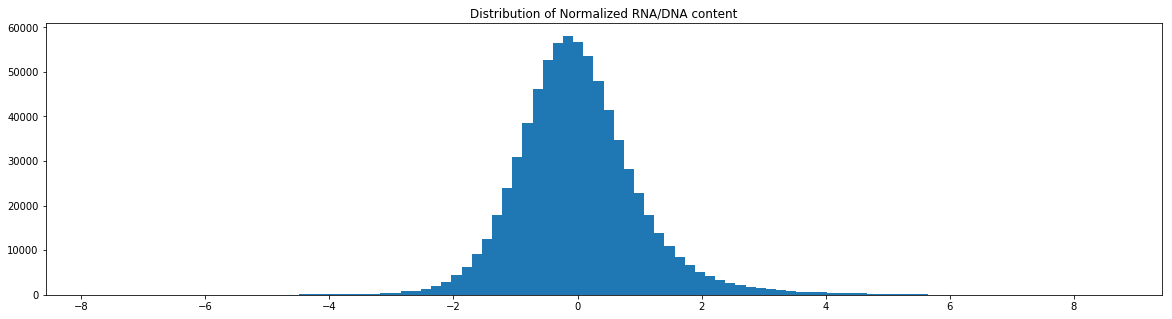

In [46]:
plt.rcParams["figure.figsize"] = (20,5)
file_name = "../data/ATAC_STARRdata/output.txt"
data_f = open(file_name).readlines()

indices = range(1, 23)                                                               
indices = [str(i) for i in indices]                                                                     

#separate file out by chromosome                                                          
chrs = {k:[] for k in indices} #initialize dictionary of sequences by chrm                

#sort reads by chromosome                                                                 

for line in data_f:
    vals = line.split("\t")
    chrm = vals[0].split(":")[0][3:]
    try:
        chrs[chrm].append(line)
    except KeyError:
        pass

sharpr_score = []
for i in range(1, 23):
    sharpr_score += [float(l.split("\t")[1]) for l in chrs[str(i)]]
sharpr_score = sorted(sharpr_score)
#sharpr_score = sorted([float(l.split("\t")[1]) for l in chrs['15']])
lengths = sorted([int(l.split("\t")[5]) for l in data_f])

#Normal distribution of SHARPR scores and region lengths
# pdf = stats.norm.pdf(sharpr_score, np.mean(sharpr_score), np.std(sharpr_score))
# plt.plot(sharpr_score, pdf, '-o')
plt.hist(np.log(sharpr_score), bins=100)
plt.title("Distribution of RNA/DNA content")
plt.show();

scaler = StandardScaler()
scaler.fit(np.log(sharpr_score))
plt.hist(scaler.transform(np.log(sharpr_score)), bins=100)
plt.title("Distribution of Normalized RNA/DNA content")
plt.show();

In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
file_name = "../data/ATAC_STARRdata/output.txt"
data_f = open(file_name).readlines()

indices = range(1, 23)                                                               
indices = [str(i) for i in indices]                                                                     

#separate file out by chromosome                                                          
chrs = {k:[] for k in indices} #initialize dictionary of sequences by chrm                

#sort reads by chromosome                                                                 

for line in data_f:
    vals = line.split("\t")
    chrm = vals[0].split(":")[0][3:]
    try:
        chrs[chrm].append(line)
    except KeyError:
        pass

sharpr_score = sorted([float(l.split("\t")[1]) for l in chrs['15']])
lengths = sorted([int(l.split("\t")[5]) for l in data_f])

#Normal distribution of SHARPR scores and region lengths
# pdf = stats.norm.pdf(sharpr_score, np.mean(sharpr_score), np.std(sharpr_score))
# plt.plot(sharpr_score, pdf, '-o')
plt.hist(np.log(sharpr_score), bins=100)
plt.title("Distribution of RNA/DNA content");

In [2]:
print "unpacking data"
x, y = (4, 500)

batch_size = 5000
#num_batches = n/batch_size

#generator for data
def generator():
    for i in ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]: #, "13", "14", "15", "16", "17", "18", "19", "20", "21"]:
        print "using chromosome ", i
        try:
            x_data, y_data = unpack_gzip("chr" + i + ".txt.gz")
        except:
            print "couldn't unpack"
#         x_data.extend(list(x))
#         y_data.extend(list(y))

        n = len(x_data)
        try:
            assert (n == len(y_data))
        except AssertionError:
            print str(n) + " and " + str(len(y_data)) + " do not match"

        #Shuffling
        d = zip(x_data, y_data)
        np.random.shuffle(d)
        x_data, y_data = zip(*d)
        x_data, y_data = np.asarray(x_data), np.asarray(y_data)

        #Taking log of RNA/DNA
        y_data=np.log(y_data)

        #4/6 as training data, 1/6 as test, 1/6 as validation                                                                                                                                  
#        train = (x_data[2*n/6:], y_data[2*n/6:])                                                                  
#         test = (x_data[:n/6], y_data[:n/6])
#         val = (x_data[n/6:2*n/6], y_data[n/6:2*n/6])

        #reshape for conv layer
        train_data = x_data.reshape(x_data.shape[0], x, y, 1) 
#        train_data = train[0].reshape(train[0].shape[0], x, y, 1)
#         test_data = test[0].reshape(test[0].shape[0], x, y, 1)
#         val_data = val[0].reshape(val[0].shape[0], x, y, 1)
        print "training shape: " + str(train_data.shape)

        #Generating sample weights
        s_weights = np.abs(stats.zscore(y_data))
        
        yield (train_data, y_data, s_weights)

unpacking data


In [3]:
classif = True
data_version = "std5"
file_suffix = ""
if classif:
    file_suffix = "_binary5.txt.gz"
else:
    file_suffix = "_better.txt.gz"


def load_chrms(test_chrm):
    #Non-batch training
    x_data = list()
    y_data = list()
    if test_chrm == 22:
        val_chrm = 1
    else:
        val_chrm = test_chrm+1

    for i in range(1, 23): #["3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22"]: #chr 2 and 14 has problems sigh
        if i != test_chrm and i != val_chrm:     
            print "using chromosome ", i
            x, y = unpack_gzip("chr" + str(i) + file_suffix)
            x_data.extend(list(x))
            y_data.extend(list(y))

    x, y = (4, 500)
    n = len(x_data)
    try:
        assert (n == len(y_data))
    except AssertionError:
        print str(n) + " and " + str(len(y_data)) + " do not match"

    #Shuffling
    d = zip(x_data, y_data)
    np.random.shuffle(d)
    x_data, y_data = zip(*d)
    x_data, y_data = np.asarray(x_data), np.asarray(y_data)

    #Taking log of RNA/DNA
    if not classif:
        y_data=np.log(y_data)
    else:
        y_data=np.asarray([max(int(i), 0) for i in y_data])

    #4/6 as training data, 1/6 as test, 1/6 as validation     
    train = (x_data, y_data)

    #reshape for conv layer
    train_data = train[0].reshape(train[0].shape[0], x, y, 1)
    print "training shape: " + str(train_data.shape)

    #Generating sample weights
    s_weights = []
    if not classif:
        s_weights = np.abs(stats.zscore(train[1]))
        
    return train, train_data, s_weights

In [4]:
#validation and test
def get_validation_set(i):
    if i == 22:
        val_chrm = 1
    else:
        val_chrm = i+1
    val = unpack_gzip("chr" + str(val_chrm) + file_suffix)
    test = unpack_gzip("chr" + str(i) + file_suffix) 

    test_data = test[0].reshape(test[0].shape[0], x, y, 1)
    val_data = val[0].reshape(val[0].shape[0], x, y, 1)

    if classif:
        val = (val[0], np.asarray([max(int(i), 0) for i in val[1]]))
        test = (test[0], np.asarray([max(int(i), 0) for i in test[1]]))
    
    return val, val_data, test, test_data

In [ ]:
#custom error
# data_mean = np.mean(y_data).astype(np.float32)
# data_variance = np.var(y_data).astype(np.float32)
# dist = tf.contrib.distributions.Normal(loc=data_mean, scale=data_variance)

def z_score_error(y_true, y_pred):
    return tf.abs(dist.cdf(y_true) - dist.cdf(y_pred)) #should this be abs or mse?

#custom kernel weights
num_motifs = 519
length_motif = 64
#with open("jasper_processed.txt", "r") as ms:
#    motifs = [l.split() for l in ms]
#motifs = np.array(motifs)

from pouya_motif_process import *
encode_motif_dict = filtered_pouya('all_encode_motifs.txt', 'lm2_082417.txt')
motifs = np.asarray(zero_padded_motifs(encode_motif_dict).values()).flatten()
print motifs.shape
motifs = motifs.reshape(1, 192, 4, 29, 1)
#motifs = motifs.reshape(1, num_motifs, 4, length_motif, 1)
motifs = motifs.transpose((0, 2, 3, 4, 1))

count = -1
def jasper_motifs(shape, dtype=None):
    global count
    count += 1
    return motifs[count]

def reg_model():
    print "building model"
    model = Sequential()
    conv_layer = (Conv2D(filters=192, #num_motifs,
                      input_shape=(x, y, 1), #input dim: 4 x 500 (x, y, 1) 
                      kernel_size= (4, 20),#length_motif), #26, #(4, 40), 
                      kernel_initializer='normal',
                      use_bias=False,
                      padding="valid",
                      activation="relu",
                      strides=(4, 1)
    )) #output at this point should be (n, 1, 437, num_motifs, 1)
    model.add(conv_layer)
#     model.add(Conv2D(filters=100, #there's really no point to this, is there? I mean at this point I should just maxpool....
#                       input_shape=(1, y-length_motif+1, num_motifs, 1),
#                       kernel_size= (1, 22, 1), #26, #(4, 40), 
#                       kernel_initializer='normal',
#                       use_bias=False,
#                       padding="valid",
#                       activation="relu",
#                       strides=(1, 1)
#     ))
    model.add(MaxPooling2D(pool_size= (1, 13), padding="valid"))                   
    model.add(Flatten())
    model.add(Dense(12, activation="relu", kernel_initializer="normal", kernel_regularizer=l2(0.01)))
    model.add(Dropout(.2))
    model.add(Dense(1, kernel_initializer="normal"))       
    
    #setting weights
#     conv_weights = conv_layer.get_weights()
#     conv_weights = motifs
#     conv_layer.set_weights(conv_weights)

    print "compiling"

    model.compile(loss='mse', optimizer='adam')

    print model.summary()
    return model

print "model created"

In [ ]:
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
tensorboard = TensorBoard(log_dir='./logs',
                                                   histogram_freq=0,
                                                   write_graph=True,
                                                   write_grads=False,
                                                   write_images=True,
                                                   embeddings_freq=0,
                                                   embeddings_layer_names=None,
                                                   embeddings_metadata=None)
checkpt = ModelCheckpoint(filepath="best_model.hdf5", monitor='val_loss', verbose=1, save_best_only=True)
#progbar = ProgbarLogger(count_mode='samples')

#batch = generator()

modela = reg_model()
modela.fit(train_data, train[1],
          batch_size=batch_size,
          #steps_per_epoch=50,
          epochs=50,
          validation_data=(val_data, val[1]),
          shuffle='batch',
          verbose=2,
          sample_weight=s_weights,
          #interval=.1,
          callbacks=[earlystopper, tensorboard, checkpt])

print "done"

In [56]:
#Start here with a trained model
#modela = load_model("best_model.hdf5")
results = modela.predict(test_data, batch_size=1000, verbose=2)
print results

[[ 0.87998217]
 [ 0.78741902]
 [ 0.88165772]
 ..., 
 [ 0.41744345]
 [ 0.53922653]
 [ 0.32638457]]


In [57]:
print "test error: ", mean_squared_error(test[1], results)
print "r, p: ", stats.pearsonr(results.flatten(), test[1].flatten())
print "r^2: ", r2_score(test[1], results)

test error:  0.181435133971
r, p:  (0.52936442928143235, 0.0)
r^2:  0.274083129593


In [5]:
def classification_model():
    print "building model"
    model = Sequential()
    conv_layer = (Conv2D(filters=123, #num_motifs,
                      input_shape=(x, y, 1), #input dim: 4 x 500 (x, y, 1) 
                      kernel_size= (4, 18),#length_motif), #26, #(4, 40), 
                      kernel_initializer='normal',
                      use_bias=False,
                      padding="valid",
                      activation="relu",
                      strides=(4, 1)
    )) 
    model.add(conv_layer)
    model.add(MaxPooling2D(pool_size= (1, 13), padding="valid"))                   
    model.add(Flatten())
    model.add(Dense(9, activation="relu", kernel_initializer="normal", kernel_regularizer=l2(0.003721)))
    model.add(Dropout(.1763))
    model.add(Dense(1, kernel_initializer="normal", activation="sigmoid")) 
    
    print "compiling"

    model.compile(loss='binary_crossentropy', optimizer='adam')

    print model.summary()
    return model

In [ ]:
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
tensorboard = TensorBoard(log_dir='./logs',
                                                   histogram_freq=0,
                                                   write_graph=True,
                                                   write_grads=False,
                                                   write_images=True,
                                                   embeddings_freq=0,
                                                   embeddings_layer_names=None,
                                                   embeddings_metadata=None)
chrm_res_dict = {}
for i in range(1, 23):
    checkpt = ModelCheckpoint(filepath="best_model_" + data_version + str(i) + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
    
    train, train_data, s_weights = load_chrms(i)
    val, val_data, test, test_data = get_validation_set(i)
    
    modela = classification_model()
    modela.fit(train_data, train[1],
              batch_size=batch_size,
              epochs=100,
              validation_data=(val_data, val[1]),
              shuffle='batch',
              verbose=2,
              callbacks=[earlystopper, tensorboard, checkpt])

    print "done training per chromosome", i
    
    results = modela.predict(test_data, batch_size=1000, verbose=2)
       
    chrm_res_dict["chr" + str(i)] = (test[1], results)

np.save(data_version + "res.npy", chrm_res_dict)

using chromosome  3
using chromosome  4
using chromosome  5
using chromosome  6
using chromosome  7
using chromosome  8
using chromosome  9
using chromosome  10
using chromosome  11
using chromosome  12
using chromosome  13
using chromosome  14
using chromosome  15
using chromosome  16
using chromosome  17
using chromosome  18
using chromosome  19
using chromosome  20
using chromosome  21
using chromosome  22
training shape: (334916, 4, 500, 1)
building model
compiling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 483, 123)       8856      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 37, 123)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4551)              0         
________________________________________________________________

In [58]:
print "roc score:", roc_auc_score(test[1], results)
precision, recall = precision_recall_curve(test[1], results)[:2]
print "auprc:", auc(recall, precision)
# prg_curve = prg.create_prg_curve(test[1], results)
# auprg = prg.calc_auprg(prg_curve)
# print(auprg)


roc score: 0.807296411761
auc: 0.799518854235


In [10]:
y_real = []
y_pred = []
chrm_res_dict = np.load("std5res.npy").item()
for i in range(1, 23):
    y_real = y_real + list(chrm_res_dict["chr" + str(i)][0])
    y_pred = y_pred + list(chrm_res_dict["chr" + str(i)][1])
print "roc score:", roc_auc_score(y_real, y_pred)
precision, recall = precision_recall_curve(y_real, y_pred)[:2]
print "auprc:", auc(recall, precision)

roc score: 0.769964045248
auprc: 0.739615158498


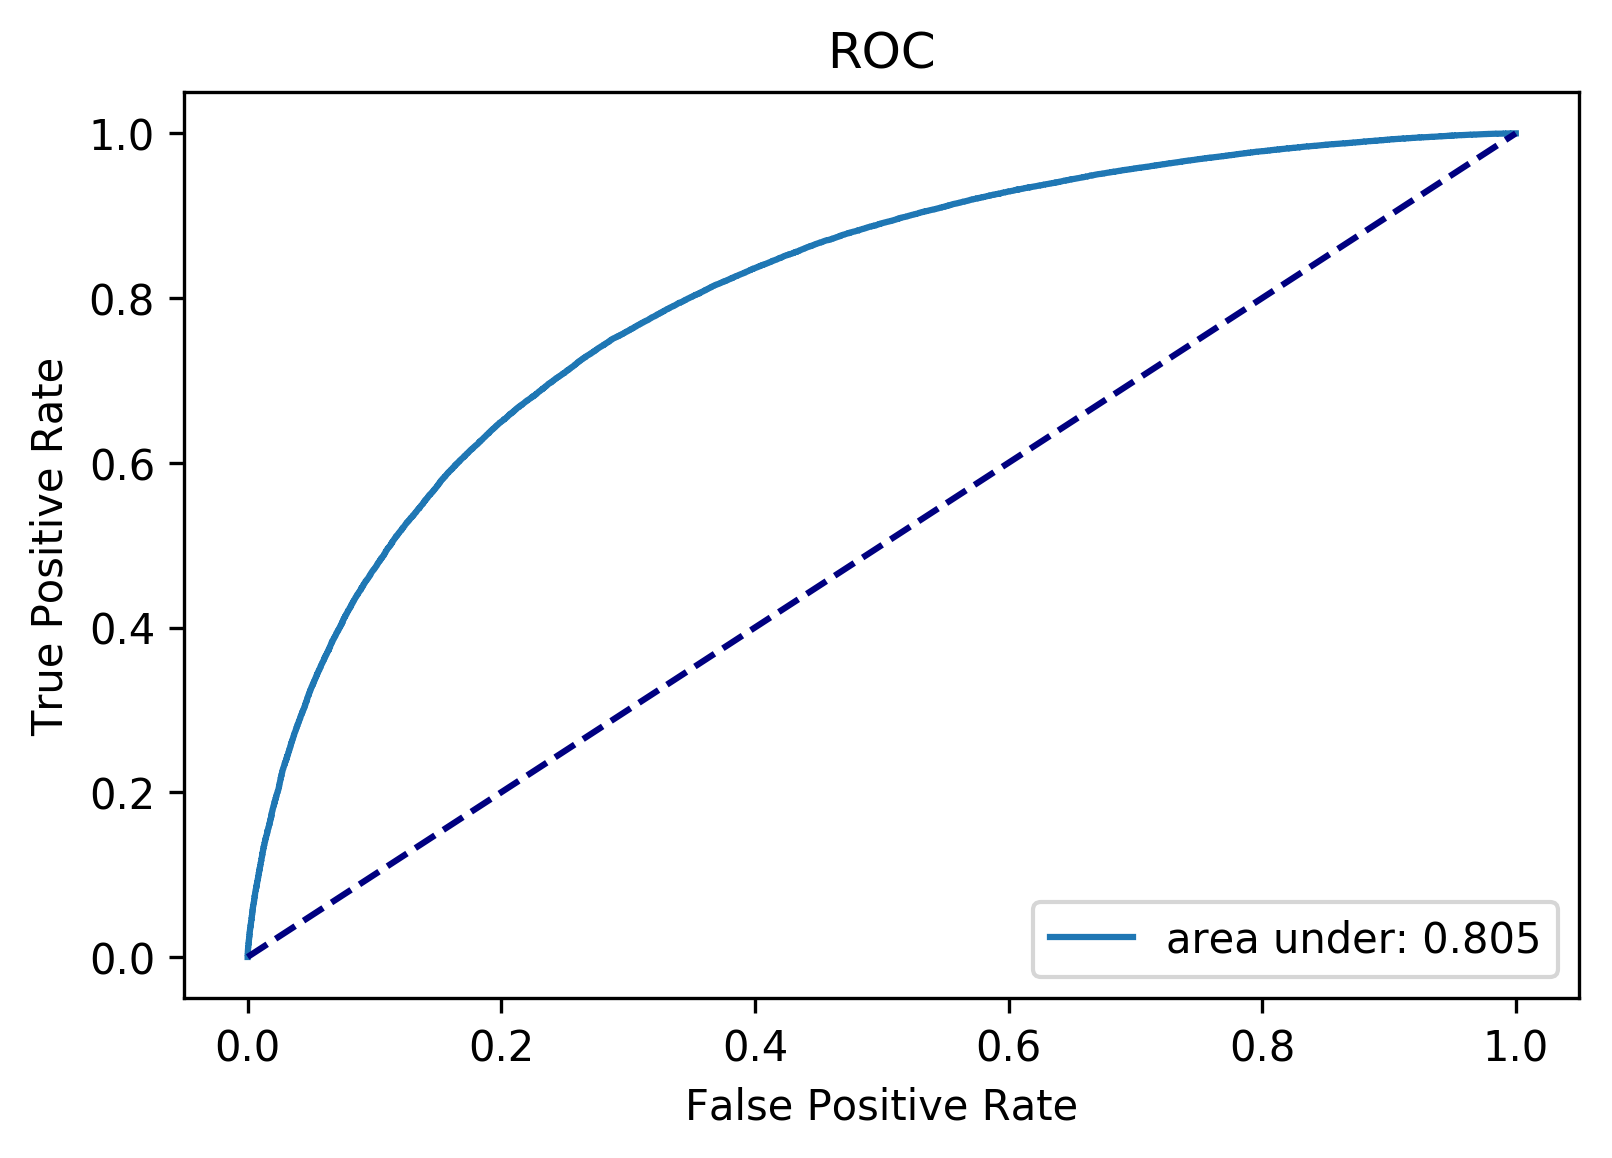

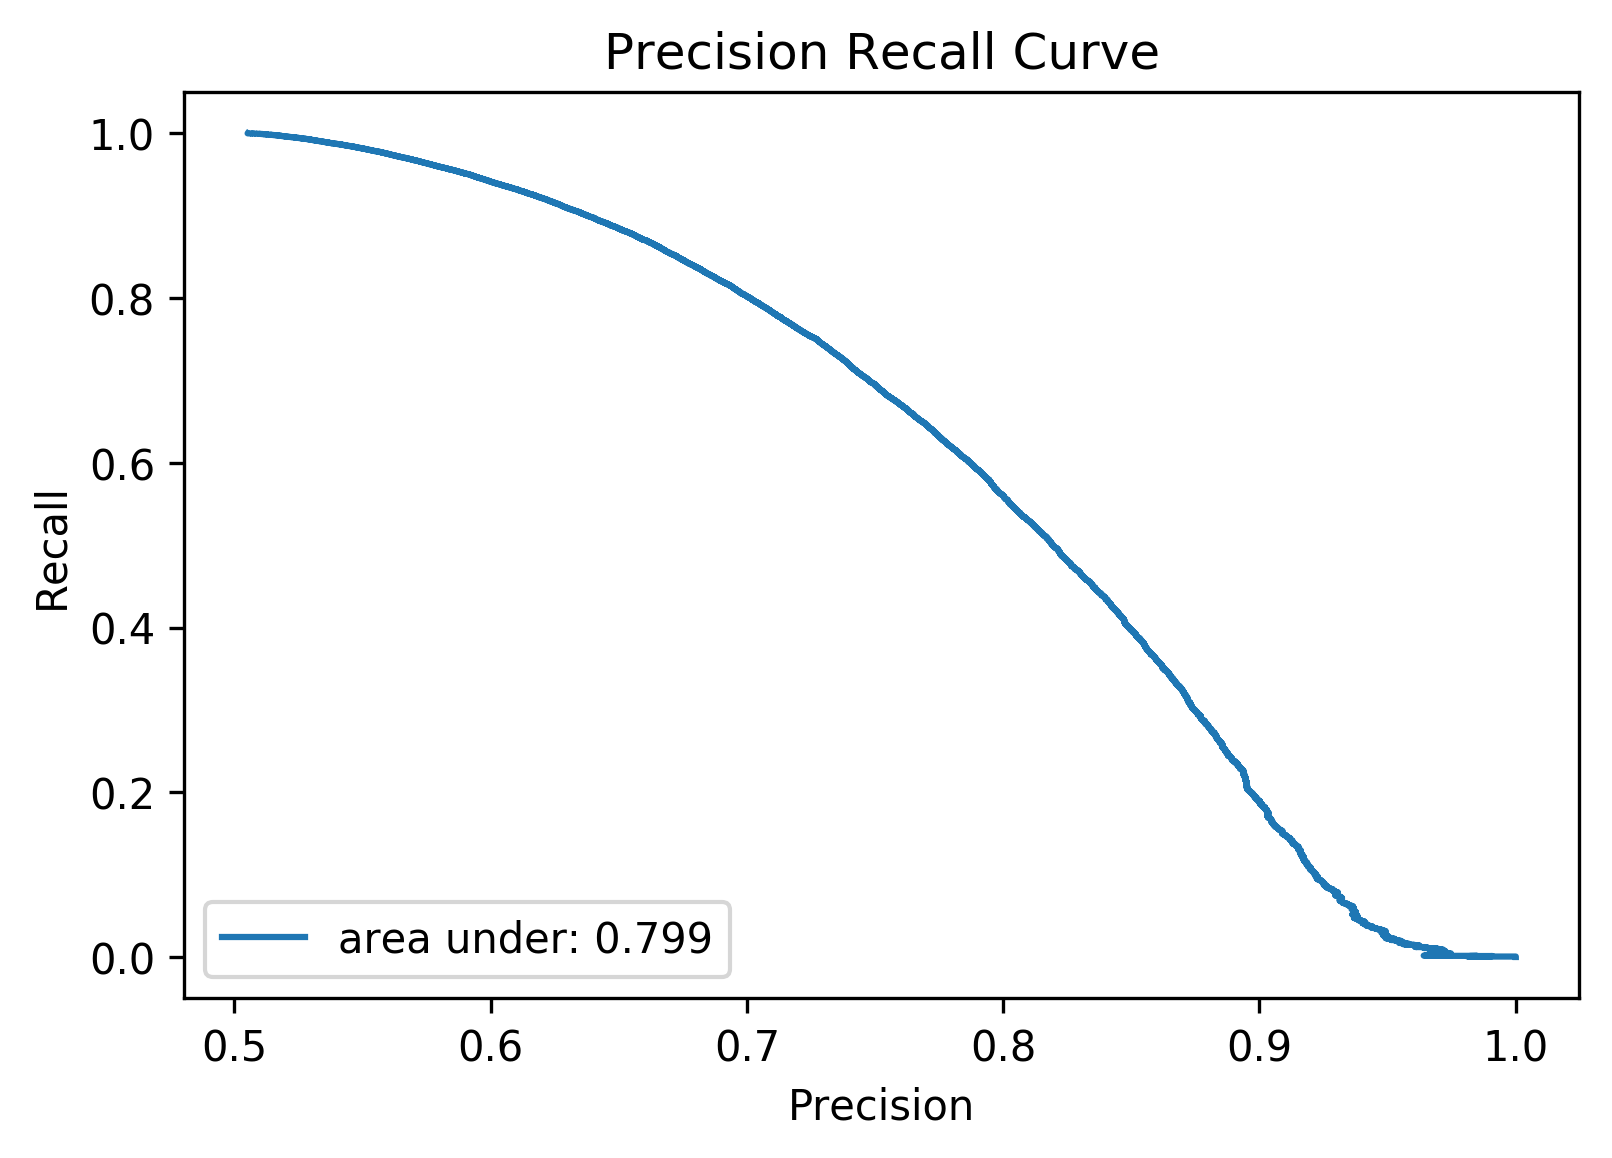

In [43]:
fpr, tpr, _ = roc_curve(y_real, y_pred)
auroc = auc(fpr, tpr)

plt.figure(dpi=300)
plt.plot(fpr, tpr, label="area under: %0.3f" % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC", fontname="Times")
plt.show()

plt.figure(dpi=300)
plt.plot(precision, recall, label="area under: %0.3f" % auc(recall, precision))
plt.legend(loc="lower left")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title("Precision Recall Curve")
plt.show()